In [1316]:
# Importación de librerías
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

# Definición de la función general para mostrar imagenes genéricas
def imshow(title, img, size=6):
    plt.figure(figsize=(size, size))
    # Antes de mostrar la imagen se verifica el número de canales
    if len(img.shape) == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

# Definición de la función general para cargar imagenes de manera aleatoria
def loadImagen(folder="valid/images"):
    # Elegir una imagen aleatorea en folder
    archivos = os.listdir(folder)
    imagen = random.choice(archivos)
    # Cargar imagen
    path = os.path.join(folder, imagen)
    return cv2.imread(path)



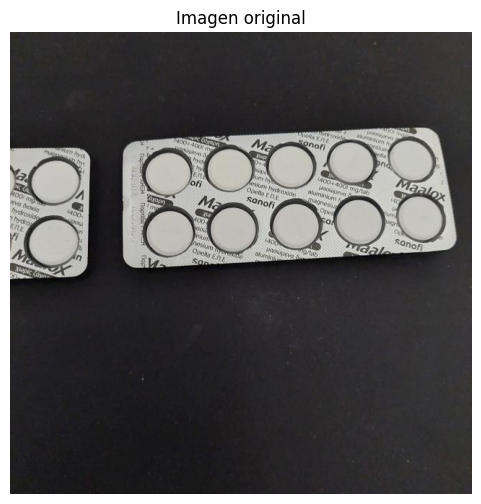

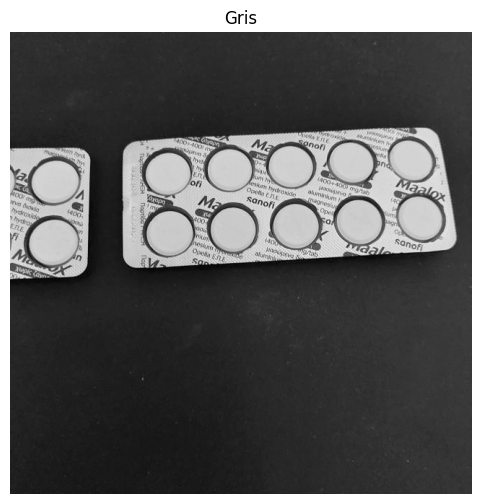

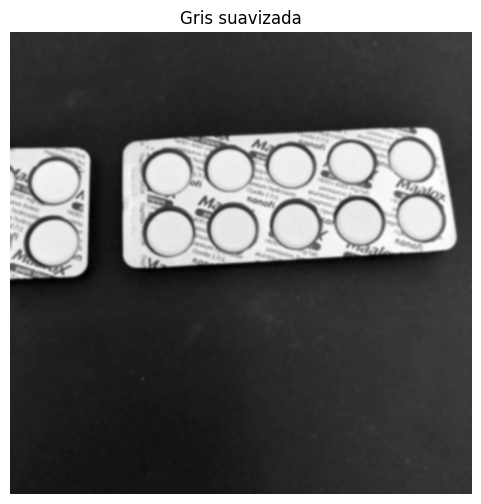

In [1317]:
# Carga de la imagen a estudiar
img = loadImagen()
imshow("Imagen original", img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_blur = cv2.GaussianBlur(gray, (7, 7), 0)
imshow("Gris", gray)
imshow("Gris suavizada", gray_blur)


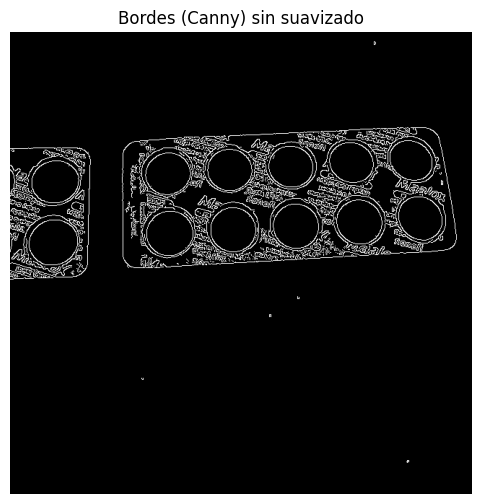

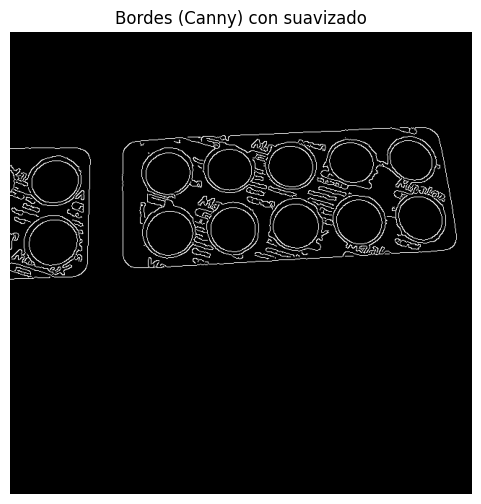

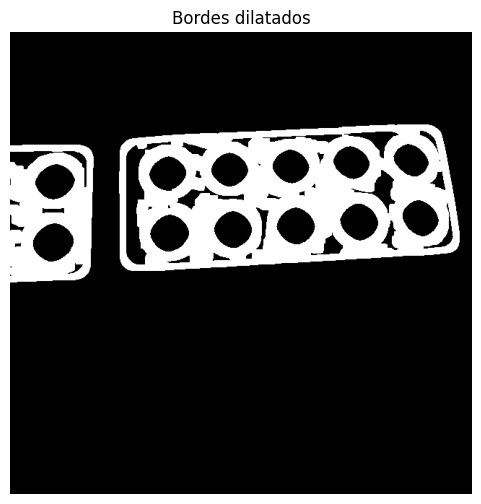

In [1318]:
# Bordes con Canny
edges = cv2.Canny(gray, 50, 150)
imshow("Bordes (Canny) sin suavizado", edges)

edges_blur = cv2.Canny(gray_blur, 50, 150)
imshow("Bordes (Canny) con suavizado", edges_blur)

# Dilatar bordes para cerrar huecos
kernel = np.ones((5, 5), np.uint8)
edges_dil_blur = cv2.dilate(edges_blur, kernel, iterations=2)
imshow("Bordes dilatados", edges_dil_blur)


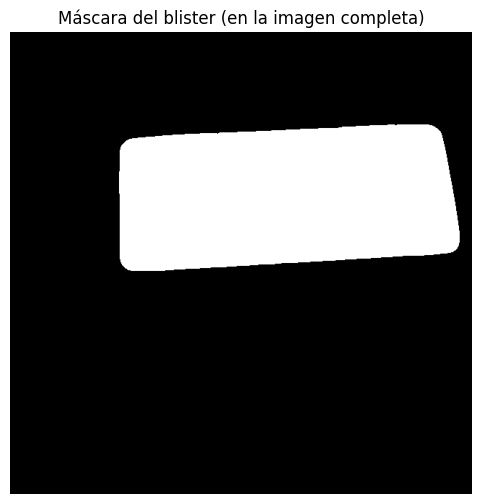

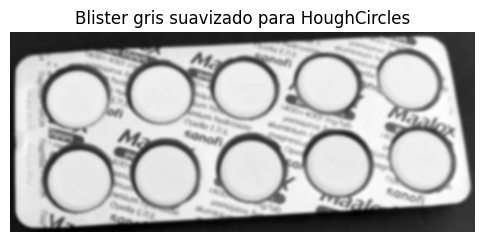

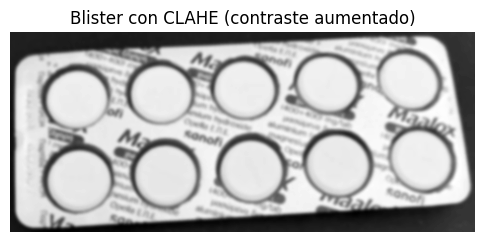

In [1319]:
contours, _ = cv2.findContours(edges_dil_blur, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

if not contours:
    raise ValueError("No se encontraron contornos en la imagen.")

# Contorno más grande = blister
c = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(c)

# Máscara del blister
blister_mask_full = np.zeros_like(gray)
cv2.drawContours(blister_mask_full, [c], -1, 255, -1)

imshow("Máscara del blister (en la imagen completa)", blister_mask_full)

# Recorte del blister
blister_crop = img[y:y+h, x:x+w]
gray_blister = gray_blur[y:y+h, x:x+w]

# Contraste adaptativo CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
gray_blister_clahe = clahe.apply(gray_blister)

altura_ref = 200  # píxeles, ejemplo
h, w = gray_blister.shape[:2]
factor = altura_ref / h
gray_blister_clahe = cv2.resize(gray_blister, (int(w*factor), altura_ref))
blister_crop = cv2.resize(blister_crop, (int(w*factor), altura_ref))

imshow("Blister gris suavizado para HoughCircles", gray_blister)
imshow("Blister con CLAHE (contraste aumentado)", gray_blister_clahe)


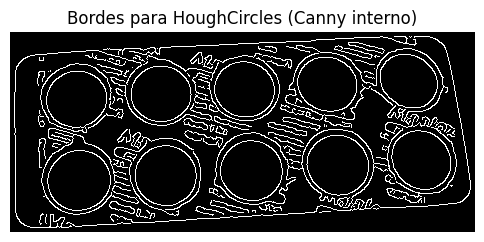

Círculo de radio 30
Círculo de radio 30
Círculo de radio 31
Círculo de radio 33
Círculo de radio 30
Círculo de radio 33
Círculo de radio 32
Círculo de radio 28
Círculo de radio 30
Círculo de radio 32


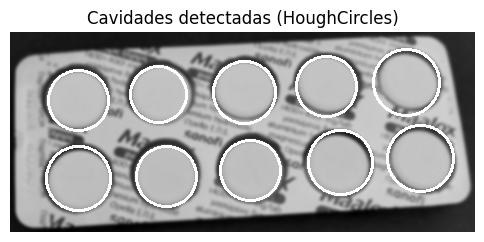

In [1320]:
circles = cv2.HoughCircles(
    gray_blister_clahe,
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=75,
    param1=100,
    param2=10,
    minRadius=25,
    maxRadius=35
)

# Parametros de HoughCircles
param1 = 100  # umbral superior de Canny interno

# Canny interno aproximado:
canny_edges = cv2.Canny(gray_blister_clahe, threshold1=param1/2, threshold2=param1)

imshow("Bordes para HoughCircles (Canny interno)", canny_edges)

blister_circles_vis = gray_blister_clahe.copy()

if circles is not None:
    circles = np.uint16(np.around(circles[0]))
    for (x_c, y_c, r_c) in circles:
        cv2.circle(blister_circles_vis, (x_c, y_c), r_c, (255, 0, 0), 2)
        print(f"Círculo de radio {r_c}")
else:
    circles = []
    print("No se detectaron cavidades.")

imshow("Cavidades detectadas (HoughCircles)", blister_circles_vis)


In [1321]:
umbral_frac_claro = 0.4  # fracción mínima de píxeles claros para considerar pastilla completa
umbral_intensidad_claro = 150  # intensidad a partir de la cual consideramos "claro"

resultados = []

for i, (x_c, y_c, r_c) in enumerate(circles):
    mask = np.zeros_like(gray_blister_clahe)
    cv2.circle(mask, (x_c, y_c), r_c - 3, 255, -1)
    
    region = gray_blister_clahe[mask == 255]

    # ---- Histograma ----
    hist, bins = np.histogram(region, bins=256, range=(0,255))
    
    # Calcular fracción de píxeles "claros"
    pix_claros = np.sum(hist[umbral_intensidad_claro:])
    fraccion_claros = pix_claros / region.size

    # ---- Regla ----
    if fraccion_claros > umbral_frac_claro:
        estado = "completa"
    elif fraccion_claros > 0.2:
        estado = "pastilla parcial / rota"
    else:
        estado = "vacía"

    resultados.append({
        "x": int(x_c),
        "y": int(y_c),
        "r": int(r_c),
        "fraccion_claros": float(fraccion_claros),
        "estado": estado
    })

# Mostrar resultados
for r in resultados:
    print(r)


{'x': 156, 'y': 144, 'r': 30, 'fraccion_claros': 1.0, 'estado': 'completa'}
{'x': 240, 'y': 138, 'r': 30, 'fraccion_claros': 1.0, 'estado': 'completa'}
{'x': 234, 'y': 60, 'r': 31, 'fraccion_claros': 0.9486343253159397, 'estado': 'completa'}
{'x': 410, 'y': 126, 'r': 33, 'fraccion_claros': 0.9099610067352003, 'estado': 'completa'}
{'x': 68, 'y': 68, 'r': 30, 'fraccion_claros': 0.9991262560069899, 'estado': 'completa'}
{'x': 396, 'y': 50, 'r': 33, 'fraccion_claros': 0.8766394895427153, 'estado': 'completa'}
{'x': 330, 'y': 130, 'r': 32, 'fraccion_claros': 0.9345758843666794, 'estado': 'completa'}
{'x': 148, 'y': 62, 'r': 28, 'fraccion_claros': 1.0, 'estado': 'completa'}
{'x': 316, 'y': 54, 'r': 30, 'fraccion_claros': 0.9545653123634775, 'estado': 'completa'}
{'x': 68, 'y': 146, 'r': 32, 'fraccion_claros': 0.9688094332445797, 'estado': 'completa'}


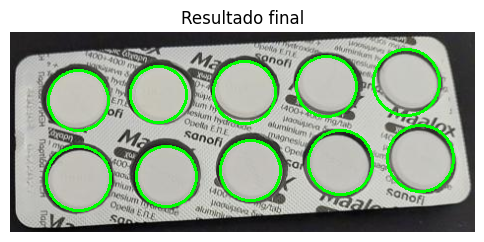

In [1322]:
resultado_vis = blister_crop.copy()

# Colores por estado
colores = {
    "completa": (0, 255, 0),
    "pastilla parcial / rota": (0, 255, 255),
    "vacía": (0, 0, 255)
}

for (circle, res) in zip(circles, resultados):
    x_c, y_c, r_c = circle
    estado = res["estado"]  # usamos la nueva etiqueta

    color = colores.get(estado, (255, 255, 255))  # blanco si etiqueta desconocida

    # Dibujar círculo
    cv2.circle(resultado_vis, (x_c, y_c), r_c, color, 2)

imshow("Resultado final", resultado_vis)
